# Lab9 - Spatial Data Analysis - Dr. Kashuk
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

#### This is a lab prepared by Dr. Kashuk. Except where specified by a comment, code is as provided in the lab. Explanatory captions for plots are provided by Sofiya Elyukin, and some variables were renamed for better clarity.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import matplotlib.patches as mpatches
import statsmodels.api as sm
import shapely
import pysal as ps
from matplotlib import colors

## Access the data within the notebook

In [3]:
# Addition to notebook from se1296

# CitiBike Station Locations
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/Station_id.csv"
!mv "Station_id.csv" "Data/Station_id.csv"

# Monthly CitiBike Usage
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CitiBike_monthly_byStation.csv"
!mv "CitiBike_monthly_byStation.csv" "Data/CitiBike_monthly_byStation.csv"

# 2010 Census Data
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/ACS_CT2010.csv"
!mv "ACS_CT2010.csv" "Data/ACS_CT2010.csv"

# Census Tract 2010 Shapefiles
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.cpg"
!mv "ct_shape.cpg" "Data/ct_shape.cpg"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.dbf"
!mv "ct_shape.dbf" "Data/ct_shape.dbf"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shp"
!mv "ct_shape.shp" "Data/ct_shape.shp"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.prj"
!mv "ct_shape.prj" "Data/ct_shape.prj"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shx"
!mv "ct_shape.shx" "Data/ct_shape.shx"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/R10_BoroCT2010.csv"
!mv "R10_BoroCT2010.csv" "Data/R10_BoroCT2010.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16006  100 16006    0     0  54747      0 --:--:-- --:--:-- --:--:--  355k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77643  100 77643    0     0   392k      0 --:--:-- --:--:-- --:--:-- 1131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0  7393k      0 --:--:-- --:--:-- --:--:-- 12.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0    10    0    10    0     0     61      0 --:--:-- --:--:-- --:--:--   322
  % Total    % Received % Xferd  Average Speed   Tim

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
shape_path="Data/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path) # this is the shapefile
ct_shape.index=ct_shape.BoroCT2010 # the census tract is now the index, this will allow joining datasets later

### Coordinate systems, projections, and transformations 

In [5]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

In [6]:
# se1296 adding code to spruce up plot, 
# http://matplotlib.org/users/legend_guide.html

red_patch = mpatches.Patch(color='red', label='Manhattan')
green_patch = mpatches.Patch(color='green', label='Bronx')
orange_patch = mpatches.Patch(color='orange', label='Brooklyn')
brown_patch = mpatches.Patch(color='brown', label='Queens')
gray_patch = mpatches.Patch(color='gray', label='Staten Island')

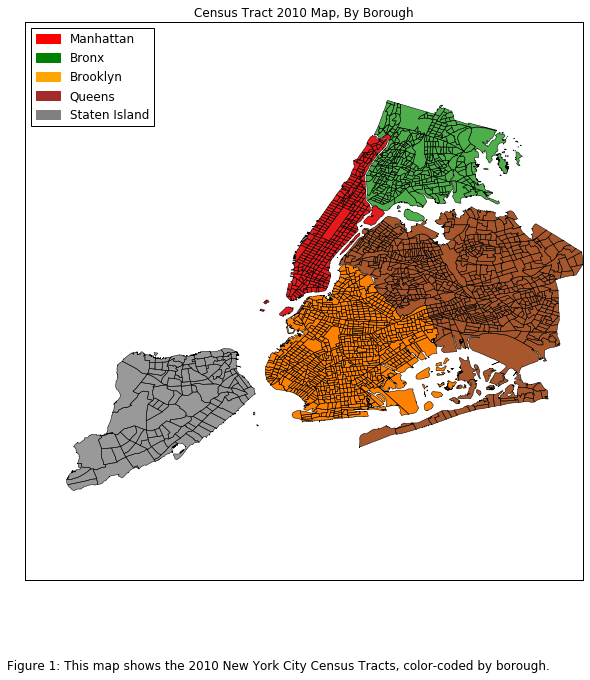

In [7]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax) 
plt.title("Census Tract 2010 Map, By Borough")
plt.legend(handles=[red_patch, green_patch, orange_patch, brown_patch, gray_patch], loc='upper left') #se1296
plt.figtext(0.1, -0.00001, '''Figure 1: This map shows the 2010 New York City Census Tracts, color-coded by borough.''',
            fontsize='large') #se1296

### Map NYC Population density

#### Load Census Data for 2010

In [8]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [9]:
# with "join" you don't specify a column like for merge. it joins based on index
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


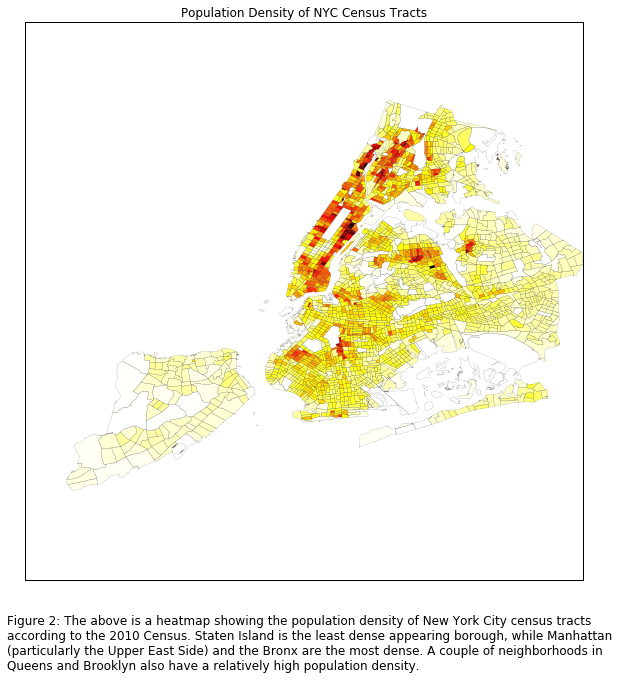

In [10]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density of NYC Census Tracts")
plt.figtext(0.1, -0.00001, '''Figure 2: The above is a heatmap showing the population density of New York City census tracts
according to the 2010 Census. Staten Island is the least dense appearing borough, while Manhattan
(particularly the Upper East Side) and the Bronx are the most dense. A couple of neighborhoods in
Queens and Brooklyn also have a relatively high population density.''',
            fontsize='large') #se1296

## Explore CitiBike data

### Load CitiBike data

In [11]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


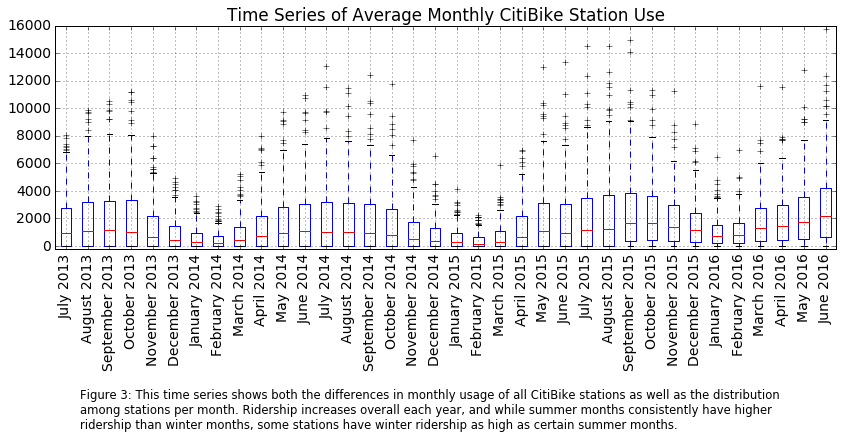

In [12]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
plt.title('Time Series of Average Monthly CitiBike Station Use')
plt.figtext(0.15, -.5, '''Figure 3: This time series shows both the differences in monthly usage of all CitiBike stations \
as well as the distribution
among stations per month. Ridership increases overall each year, and while summer months consistently have higher
ridership than winter months, some stations have winter ridership as high as certain summer months.''',
            fontsize='small') #se1296

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


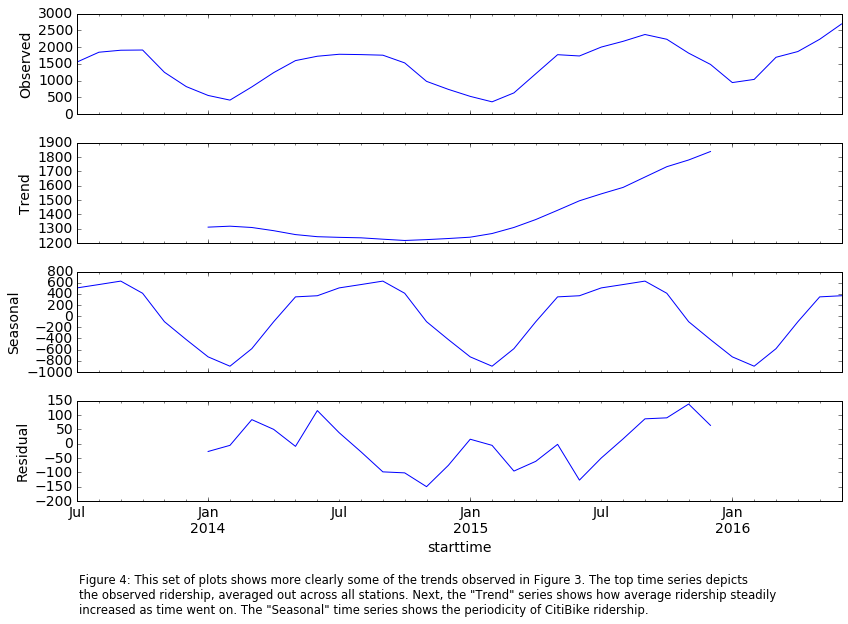

In [13]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_monthly_avg=df_bike_monthly.mean(1).resample('M').mean()
df_monthly_avg.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_monthly_avg.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot() #this is all 4 graphs
plt.figtext(0.1, -0.08, '''Figure 4: This set of plots shows more clearly some of the trends observed in Figure 3. \
The top time series depicts 
the observed ridership, averaged out across all stations. Next, the "Trend" series shows how average ridership steadily
increased as time went on. The "Seasonal" time series shows the periodicity of CitiBike ridership.''',
            fontsize='small') #se1296

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [14]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [15]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [16]:
CTcodes=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    CTcodes.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4], 
station_id['BoroCT2010']=CTcodes

% 100.


In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

##### se1296 note for comprehension: the above code functioned as a "spatial join". The station geometries were intersected with the census tract geometries, and for each station a value of TRUE was returned for the one and only tract whose geometry the station fell within. The code for that tract was then appended into a new column in the station_id dataframe.

### Add Monthly rides to the station GeoDataFrame with CT code

In [18]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [19]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add the monthly average rides to the CT shapefile 

In [20]:
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


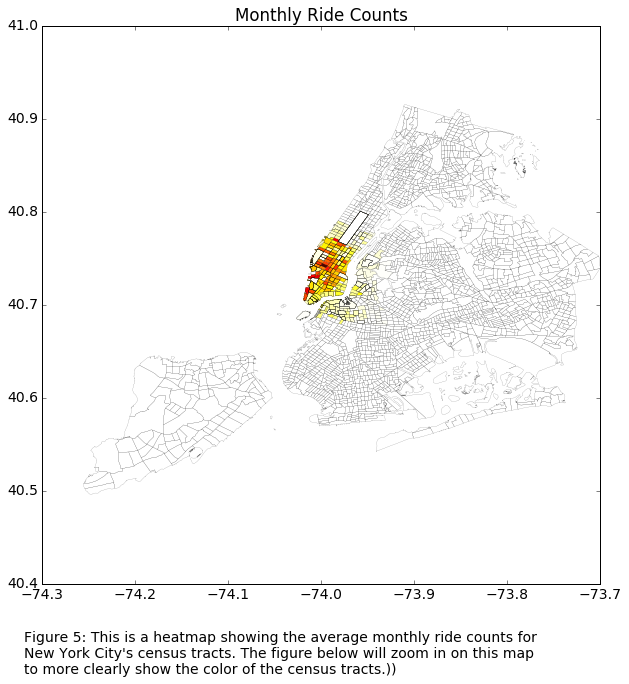

In [21]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")
plt.figtext(0.1, -0.00001, '''Figure 5: This is a heatmap showing the average monthly ride counts for
New York City's census tracts. The figure below will zoom in on this map
to more clearly show the color of the census tracts.))''')

### Removing the CTs that are out of zoom boundries

In [22]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [23]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

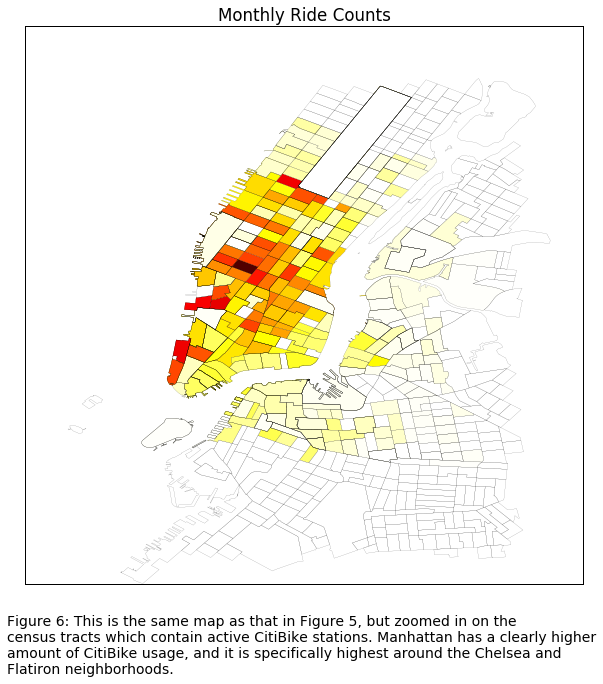

In [24]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")
plt.figtext(0.1, -0.00001, '''Figure 6: This is the same map as that in Figure 5, but zoomed in on the
census tracts which contain active CitiBike stations. Manhattan has a clearly higher
amount of CitiBike usage, and it is specifically highest around the Chelsea and
Flatiron neighborhoods.''')

### Export Shapefile CTs in the CitiBike Zone

In [25]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [26]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [27]:
qW_CT[10]
qW_CT

In [28]:
qW_CT.cardinalities[10] # how many neighbors (i.e. count above output)

9

#### Matrix of Weights

In [29]:
Wmatrix, ids = qW_CT.full()

In [30]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [31]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [32]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [33]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag

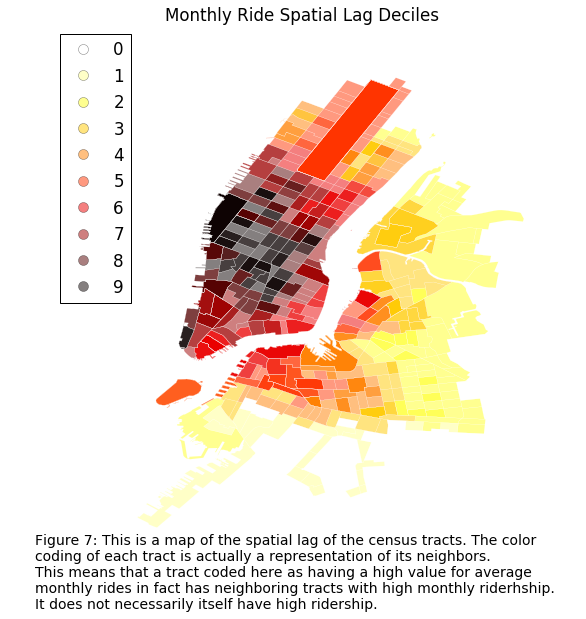

In [34]:
# The current color value of each tract is a representation of its neighbors,
# not itself. I.e., if tract has high value, it just means its neighbors have a high value
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")
plt.figtext(0.1, -0.00001, '''Figure 7: This is a map of the spatial lag of the census tracts. The color
coding of each tract is actually a representation of its neighbors.
This means that a tract coded here as having a high value for average
monthly rides in fact has neighboring tracts with high monthly riderhship.
It does not necessarily itself have high ridership.''')
# gov island and the piers are the same census tract, that's why it has neighbors

## Global  Spatial Autocorrelation

In [35]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

### Moran Scatterplot

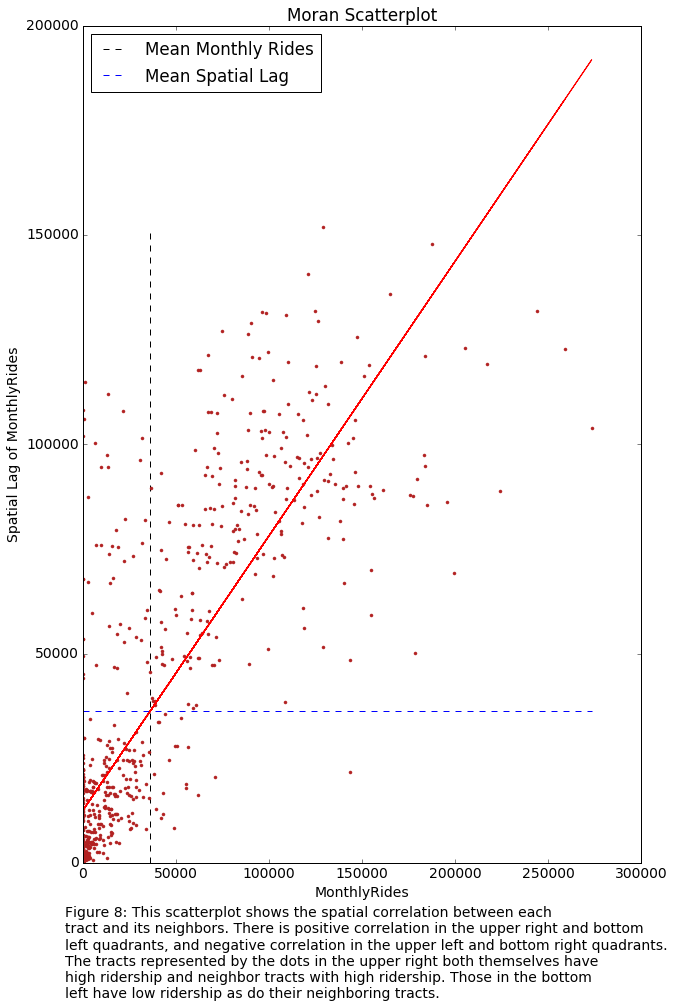

In [36]:
f, ax = plt.subplots(1, figsize=(10, 15))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--', label='Mean Monthly Rides')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--', color='b', label='Mean Spatial Lag')
plt.legend(loc='upper left')
# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')
plt.figtext(0.1, -0.0000001, '''Figure 8: This scatterplot shows the spatial correlation between each 
tract and its neighbors. There is positive correlation in the upper right and bottom
left quadrants, and negative correlation in the upper left and bottom right quadrants.
The tracts represented by the dots in the upper right both themselves have
high ridership and neighbor tracts with high ridership. Those in the bottom
left have low ridership as do their neighboring tracts.''')

### Moran's I

In [37]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT) #using pysal   #click inside here, then press shift+tab to see other args

In [38]:
I_MonthlyRide.I, I_MonthlyRide.p_sim # first number is same as polyfit above, second number is the point of pysal, gives you 
#the p-value of of the I, i.e. how significant it is

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [39]:
I_MonthlyRide.sim[0:10]

array([ 0.00644787,  0.02709919, -0.03483674, -0.00481378,  0.01065488,
       -0.0072876 , -0.00768685,  0.00011359,  0.01395908,  0.0326934 ])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [40]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

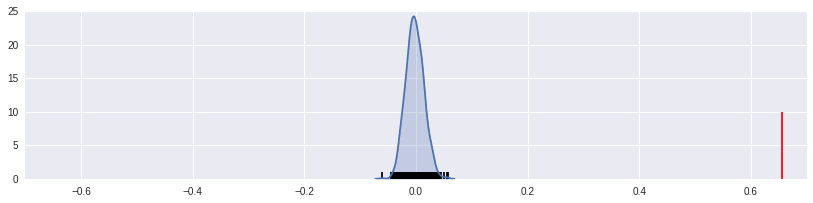

In [41]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

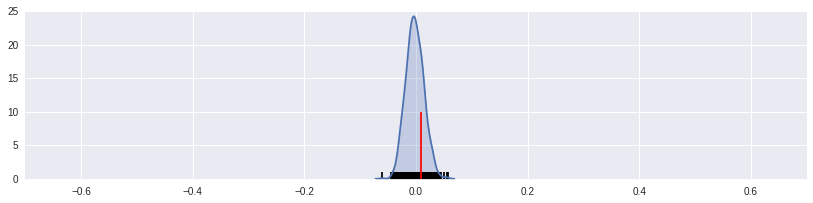

In [42]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [43]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [44]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.212,  0.39 ,  0.386,  0.427]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [45]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

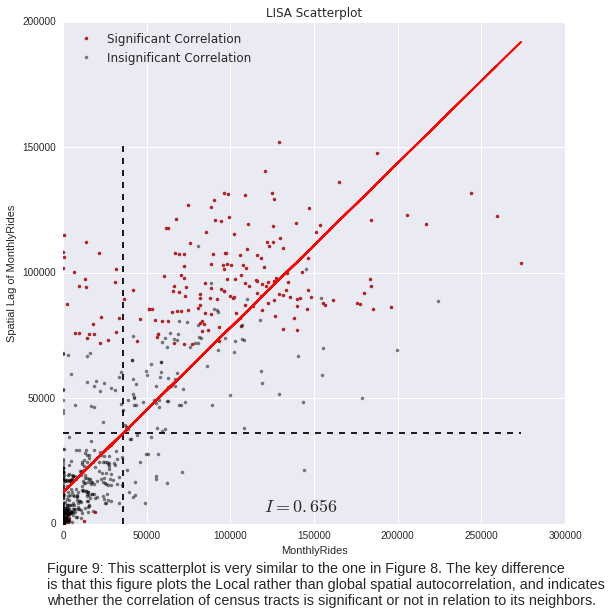

In [46]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick', label='Significant Correlation')
plt.plot(insigs, W_insigs, '.k', alpha=.5, label='Insignificant Correlation')
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)
plt.legend(loc='upper left', fontsize='medium')
 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('LISA Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')
plt.figtext(0.1, -0.0000001, '''Figure 9: This scatterplot is very similar to the one in Figure 8. The key difference
is that this figure plots the Local rather than global spatial autocorrelation, and indicates
whether the correlation of census tracts is significant or not in relation to its neighbors.''', fontsize='large')

### Hot and Cold spots 

In [47]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 191
Number of Coldspots: 239


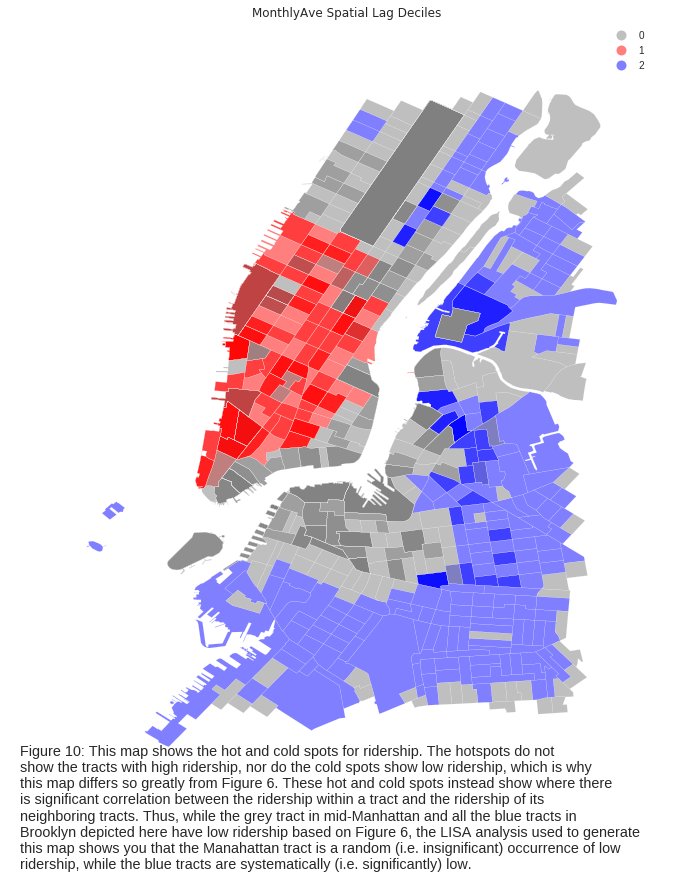

In [48]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(11, 13))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")
plt.figtext(0.1, -0.005, '''Figure 10: This map shows the hot and cold spots for ridership. The hotspots do not
show the tracts with high ridership, nor do the cold spots show low ridership, which is why 
this map differs so greatly from Figure 6. These hot and cold spots instead show where there
is significant correlation between the ridership within a tract and the ridership of its
neighboring tracts. Thus, while the grey tract in mid-Manhattan and all the blue tracts in
Brooklyn depicted here have low ridership based on Figure 6, the LISA analysis used to generate
this map shows you that the Manahattan tract is a random (i.e. insignificant) occurrence of low
ridership, while the blue tracts are systematically (i.e. significantly) low.''', fontsize='large')